### Main Notebook for visualisation 

Setup for required libraries:

In [1]:
%pip install numpy pandas matplotlib keras scikit-learn tensorflow


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Importing data for DNN training (using Pandas):

In [2]:
import pandas as pd
import numpy as np

file_path = 'dtag/grid/4_agents/4/velocity_metrics.csv'
file_path2 = 'dtag/grid/4_agents/4/idleness.csv'
file_path3 = 'dtag/grid/4_agents/4/vulnerabilities.csv'
file_path4 = 'dtag/grid/4_agents/4/distance_metrics.csv'


df_vel = pd.read_csv(file_path, sep=';', header=None)
df_idle = pd.read_csv(file_path2, sep=';',header=None)
df_vuln = pd.read_csv(file_path3, sep=';',header=None)
df_dist = pd.read_csv(file_path4, sep=';',header=None)



In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, LSTM
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
tf.random.set_seed(7)

2023-10-20 11:50:57.885709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Doing it for one Node as i cant get it working for more than 1 atm:

In [55]:
vel_data = df_vel.iloc[:, 1]
idle_data = df_idle.iloc[:, 1]
vuln_data = df_vuln.iloc[:, 1]
dist_data = df_dist.iloc[:, 1]

df = pd.concat([vel_data,idle_data,dist_data,vuln_data],axis=1)
df = df.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values
df = df.dropna()

threshold = 50

df.iloc[df.iloc[:, -1] < threshold, -1] = 0
df.iloc[df.iloc[:, -1] >= threshold, -1] = 1
df.iloc[:,-1].value_counts()


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,61.0,-21543.2,-21534.9,-21527.0,-21518.9,-21509.6,-21551.5,5.2,-21524.7,-21548.7,...,-21528.5,-21500.6,-21495.7,-21487.5,-21523.4,3.9,-21546.3,-21504.2,-21462.8,-21471.1
1,62.0,-21542.2,-21533.9,-21526.0,-21517.9,-21508.6,-21550.5,6.2,-21523.7,-21547.7,...,-21527.5,-21499.6,-21494.7,-21486.5,-21522.4,4.9,-21545.3,-21503.2,-21461.8,-21470.1
2,63.0,-21541.2,-21532.9,-21525.0,-21516.9,-21507.6,-21549.5,7.2,-21522.7,-21546.7,...,-21526.5,-21498.6,-21493.7,-21485.5,-21521.4,5.9,-21544.3,-21502.2,-21460.8,-21469.1
3,64.0,-21540.2,-21531.9,-21524.0,-21515.9,-21506.6,-21548.5,8.2,-21521.7,-21545.7,...,-21525.5,-21497.6,-21492.7,-21484.5,-21520.4,6.9,-21543.3,-21501.2,-21459.8,-21468.1
4,65.0,-21539.2,-21530.9,-21523.0,-21514.9,-21505.6,0.9,9.2,-21520.7,-21544.7,...,-21524.5,-21496.6,-21491.7,-21483.5,-21519.4,7.9,-21542.3,-21500.2,-21458.8,-21467.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21482,21610.6,inf,inf,inf,inf,inf,81.7,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
21483,21611.6,inf,inf,inf,inf,inf,82.7,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
21484,21612.6,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
21485,21613.6,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


Train and test split:

In [5]:
dataset = df.to_numpy()
# dataset[2] = scaler.fit_transform(dataset[2])


# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
df.iloc[:,3].value_counts()
# df.iloc[:,75:100]
# df.iloc[:,50:75]




15033 6443


1
0.0    20456
1.0     1020
Name: count, dtype: int64

In [6]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0:-1]
		dataX.append(a)
		dataY.append(dataset[i + look_back, -1])
	return np.array(dataX), np.array(dataY)

look_back = 50

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainY)

[0. 0. 0. ... 0. 0. 0.]


In [7]:
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[-1]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[-1]))
trainX.shape

(14982, 50, 3)

In [8]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, trainX.shape[-1])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
14982/14982 - 87s - loss: 0.1966 - accuracy: 0.9525 - 87s/epoch - 6ms/step
Epoch 2/10
14982/14982 - 88s - loss: 0.1897 - accuracy: 0.9525 - 88s/epoch - 6ms/step
Epoch 3/10
14982/14982 - 96s - loss: 0.1891 - accuracy: 0.9525 - 96s/epoch - 6ms/step
Epoch 4/10
14982/14982 - 93s - loss: 0.1891 - accuracy: 0.9525 - 93s/epoch - 6ms/step
Epoch 5/10
14982/14982 - 89s - loss: 0.1892 - accuracy: 0.9525 - 89s/epoch - 6ms/step
Epoch 6/10
14982/14982 - 95s - loss: 0.1891 - accuracy: 0.9525 - 95s/epoch - 6ms/step
Epoch 7/10
14982/14982 - 100s - loss: 0.1886 - accuracy: 0.9525 - 100s/epoch - 7ms/step
Epoch 8/10
14982/14982 - 97s - loss: 0.1884 - accuracy: 0.9525 - 97s/epoch - 6ms/step
Epoch 9/10
14982/14982 - 93s - loss: 0.1883 - accuracy: 0.9525 - 93s/epoch - 6ms/step
Epoch 10/10
14982/14982 - 79s - loss: 0.1882 - accuracy: 0.9525 - 79s/epoch - 5ms/step


In [40]:

trainPredict = model.predict(trainX).T[0]
testPredict = model.predict(testX).T[0]
print(trainPredict.max())
print(trainY)
# Apply a threshold to convert the probabilities to binary predictions (0 or 1)
threshold = 0.08  # Adjust the threshold if needed
trainPredict_binary = (trainPredict > threshold).astype(int)
testPredict_binary = (testPredict > threshold).astype(int)
print(trainPredict_binary)
print(trainY)


200/200 [==============================] - 1s 3ms/step
0.090493776
[0. 0. 0. ... 0. 0. 0.]
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


In [41]:
from sklearn.metrics import accuracy_score, f1_score

# Compute accuracy and F1 score
train_accuracy = accuracy_score(trainY, trainPredict_binary)
test_accuracy = accuracy_score(testY, testPredict_binary)

train_f1_score = f1_score(trainY, trainPredict_binary)
test_f1_score = f1_score(testY, testPredict_binary)

print('Train Accuracy:', train_accuracy)
print('Test Accuracy:', test_accuracy)

print('Train F1 Score:', train_f1_score)
print('Test F1 Score:', test_f1_score)

Train Accuracy: 0.9264450674142304
Test Accuracy: 0.9285043804755945
Train F1 Score: 0.045060658578856154
Test F1 Score: 0.04192872117400419


In [42]:
test = pd.DataFrame(trainPredict_binary)
test.value_counts()

0    14540
1      442
Name: count, dtype: int64

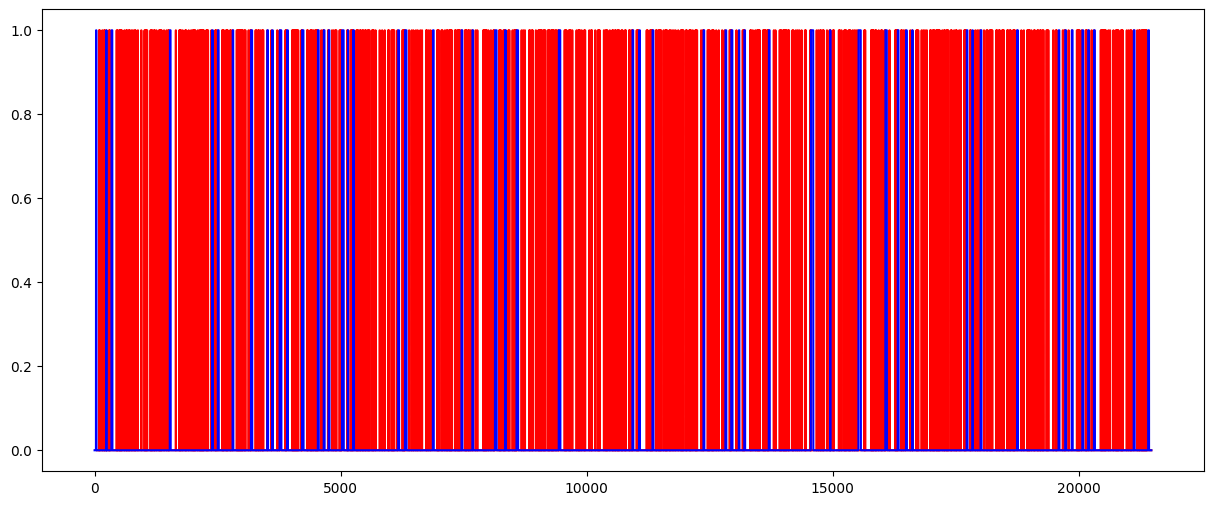

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset[:,2])
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict_binary)+look_back] = trainPredict_binary
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:,2])
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict_binary)+(look_back*2)+1:len(dataset[:,2])-1] = testPredict_binary
# plot baseline and predictions
plt.plot(trainPredictPlot,'r')
plt.plot(testPredictPlot,'r')
plt.plot(dataset[:,-1],'b')
plt.show()